# Read in data

In [1]:
import pandas as pd
import altair as alt
import numpy as np
import datetime

In [2]:
rankings_global_and_biome = pd.read_csv('param_rankings_11Feb2022.csv')

In [3]:
param_descriptions = pd.read_csv('param_list_CLM5PPE.csv')

# Process data

In [4]:
rankings=rankings_global_and_biome
rankings=rankings.drop(columns=['Unnamed: 0'])
rankings['biome_type']=rankings.biome.where(rankings.biome=='global','regional')
param_descriptions['param_name']=param_descriptions['param']

In [5]:
variables = ['EFLX_LH_TOT', 'FSH', 'Q2M','ET',
             'TAUX',        'TAUY','U10',
             'TSKIN',       'TSA', 'FIRE',
             'albedo_allSW','FSA', 'alb_DifNIR','alb_DirNIR','alb_DifVis','alb_DirVis']
variable_categories = ['WaterAndTurbFluxes','WaterAndTurbFluxes','WaterAndTurbFluxes','WaterAndTurbFluxes',
            'MomentumAndResistance','MomentumAndResistance','MomentumAndResistance',
            'TemperatureAndLW','TemperatureAndLW','TemperatureAndLW',
            'AlbedoAndSW','AlbedoAndSW','AlbedoAndSW','AlbedoAndSW','AlbedoAndSW','AlbedoAndSW']
df_variable_crosswalk = pd.DataFrame({'variable': variables, 
                          'variable_category': variable_categories})

In [6]:
rankings_merged = (pd.merge(rankings, param_descriptions, how='left',on='param_name'))
rankings_merged = (pd.merge(rankings_merged, df_variable_crosswalk, how='left',on='variable'))

In [7]:
rankings_merged['Category3'] = rankings_merged['Category2'].where(~rankings_merged['Category2'].isin(['Plant photosynthesis numerical implementation',
                                                                                                      'Soil nitrogen cycle',
                                                                                                      'Soil decomposition',
                                                                                                      'Plant carbon and nitrogen allocation',
                                                                                                      'Plant respiration',
                                                                                                      'Plant nitrogen fixation and uptake',
                                                                                                     'Biomass heat storage'
                                                                                                     ]),
                                                                  'Other')

In [8]:
rankings_merged = rankings_merged[~(rankings_merged.variable=='ET')&
                                  ~(rankings_merged.variable=='TAUY')&
                                  ~(rankings_merged.variable=='alb_DirNIR')&
                                  ~(rankings_merged.variable=='alb_DirVis')&
                                 ~(rankings_merged.variable=='alb_DifNIR')&
                                 ~(rankings_merged.variable=='alb_DifVis')]

In [9]:
rankings_merged['criteria_type']=rankings_merged['variable']+'_'+rankings_merged['measure']

In [10]:
datetag = datetime.datetime.now().strftime("%d%b%Y")

# List of ranked top parameters (export to csv)

In [11]:
source=rankings_merged
#source = source[source['rank']<=3]
param_list = pd.pivot_table(source, index=["param_name"], columns=["variable"], values=["rank"], aggfunc='count')
param_list['total']=source['rank'].groupby(source["param_name"]).count().values
param_list.columns = [f'{j}_{i}' for i, j in param_list.columns]
param_list=param_list.rename(columns=
                             {"EFLX_LH_TOT_rank":"EFLX_LH_TOT",
                             "FIRE_rank":"FIRE",
                             "FSA_rank":"FSA",
                             "FSH_rank":"FSH",
                             "LAC_rank":"LAC",
                             "Q2M_rank":"Q2M",
                              "TSA_rank":"TSA",
                              "TAUX_rank":"TAUX",
                              "TSKIN_rank":"TSKIN",
                              "U10_rank":"U10",
                              "albedo_allSW_rank":"albedo_allSW",
                              "_total":"total"
                             })
#
#param_list.to_csv('Top_Params_v2.csv')

In [12]:
param_list=param_list.fillna(0)
param_list['Water_and_Turbulent']=(param_list['EFLX_LH_TOT']+
                                   param_list['FSH']+
                                   param_list['Q2M'])/3
param_list['Albedo_and_SW']=(param_list['albedo_allSW']+
                             param_list['FSA'])/2
param_list['Temperature']=(param_list['FIRE']+
                           param_list['TSA']+
                           param_list['TSKIN'])/3
param_list['Wind_and_Roughness']=(param_list['TAUX']+
                           param_list['U10'])/2

param_list['total_weighted']=(param_list['Water_and_Turbulent']+
                              param_list['Albedo_and_SW']+
                              param_list['Temperature']+
                              param_list['Wind_and_Roughness']+
                              param_list['LAC'])

In [13]:
param_list=(pd.merge(param_list, param_descriptions, how='left',on='param_name'))
param_list.to_csv('Param_counts'+datetag+'.csv')

In [14]:
param_list.sort_values(by='total', ascending=False)[0:10]

param_name  EFLX_LH_TOT  FIRE  FSA   FSH  LAC   Q2M  \
68                 zetamaxstable          2.0   9.0  2.0   5.0  0.0   5.0   
70                          zsno          2.0   6.0  4.0   5.0  0.0   4.0   
30               medlynintercept          8.0   2.0  3.0  10.0  1.0   9.0   
20                          kmax         13.0   8.0  5.0   9.0  1.0   2.0   
12                           fff         10.0   8.0  1.0   7.0  0.0  12.0   
31                   medlynslope         12.0   5.0  3.0   8.0  1.0   5.0   
29  maximum_leaf_wetted_fraction          5.0   4.0  1.0   9.0  4.0   8.0   
16                        jmaxb0          8.0   5.0  3.0   5.0  0.0   1.0   
34                         nstem          0.0   1.0  2.0   0.0  0.0   4.0   
17                        jmaxb1          4.0   6.0  2.0   5.0  0.0   2.0   

    TAUX   TSA  TSKIN  ...  Albedo_and_SW  Temperature  Wind_and_Roughness  \
68   5.0  15.0    8.0  ...            2.0    10.666667                 6.5   
70  10.0   8.0    6.0  ...            4.0     6.666667                10.5   
30  11.0   5.0    5.0  ...            2.5     4.000000                 6.5   
20   1.0   7.0    8.0  ...            3.0     7.666667                 1.0   
12   2.0   2.0    5.0  ...            2.0     5.000000                 3.5   
31   5.0   5.0    4.0  ...            2.5     4.666667                 3.0   
29   1.0   4.0    3.0  ...            1.0     3.666667                 1.0   
16   4.0   2.0    6.0  ...            3.5     4.333333                 3.5   
34  18.0   2.0    1.0  ...            2.0     1.333333                13.0   
17   6.0   3.0    5.0  ...            1.5     4.666667                 5.0   

    total_weighted                         param  \
68       23.166667                 zetamaxstable   
70       24.833333                          zsno   
30       23.000000               medlynintercept   
20       20.666667                          kmax   
12       20.166667                           fff   
31       19.500000                   medlynslope   
29       17.000000  maximum_leaf_wetted_fraction   
16       16.000000                        jmaxb0   
34       17.666667                         nstem   
17       14.833333                        jmaxb1   

                                          Description  \
68  Max value zeta ("height" used in Monin-Obukhov...   
70                 Momentum roughness length for snow   
30  Medlyn intercept of conductance-photosynthesis...   
20                      Plant segment max conductance   
12         Decay factor for fractional saturated area   
31  Medlyn slope of conductance-photosynthesis rel...   
29  Maximum fraction of leaf that may be wet prior...   
16  the baseline proportion of nitrogen allocated ...   
34  Stem number; number of individuals per meter s...   
17  determines response of electron transport rate...   

                                     Category1  \
68  Sensible, latent heat, and momentum fluxes   
70  Sensible, latent heat, and momentum fluxes   
30      Stomatal resistance and photosynthesis   
20                            Plant hydraulics   
12                                   Hydrology   
31      Stomatal resistance and photosynthesis   
29                                   Hydrology   
16                     Photosynthetic capacity   
34                        Biomass heat storage   
17                     Photosynthetic capacity   

                                            Category2     Component Notes  
68    Land surface roughness / aerodynamic resistance     Ecosystem   NaN  
70    Land surface roughness / aerodynamic resistance          Snow   NaN  
30  Plant stomatal conductance and water use effic...         Plant   NaN  
20                                   Plant hydraulics         Plant   NaN  
12                   Soil and surface water hydrology          Soil   NaN  
31  Plant stomatal conductance and water use effic...         Plant   NaN  
29                Canopy hydrol

# Code for visualizations

In [93]:
source=rankings_merged

In [94]:
biome_order=['Ice sheet',
             'Subtropical desert',
             'Temperate grassland/desert',
             'Tundra',
             'Woodland/shrubland',
             'Temperate seasonal forest',
             'Tropical seasonal forest/savanna',
             'Temperate rain forest',
             'Boreal forest',
             'Tropical rain forest',
             'global']

In [95]:
var_list=np.unique(rankings_merged.variable).tolist()
var_dropdown = alt.binding_select(options=var_list)
var_select = alt.selection_single(fields=['variable'], bind=var_dropdown, name="Variable",
                                 init={'variable':'EFLX_LH_TOT'})

region_list=np.unique(rankings_merged.biome).tolist()
region_dropdown = alt.binding_select(options=region_list)
region_select = alt.selection_single(fields=['biome'], bind=region_dropdown, name="Biome",
                                 init={'biome':'global'})

measure_list = np.unique(rankings_merged.measure).tolist()
measure_dropdown = alt.binding_select(options=measure_list)
measure_select = alt.selection_single(fields=['measure'], bind=measure_dropdown, name="Measure",
                                 init={'measure':'mean'})

params_list=rankings_merged.param_name.value_counts().index.tolist()
param_dropdown = alt.binding_select(options=np.unique(params_list).tolist())
param_select = alt.selection_single(fields=['param_name'], bind=param_dropdown, name="Parameter",
                                 init={'param_name':'medlynslope'})

category2_list=rankings_merged.Category2.value_counts().index.tolist()
category_dropdown = alt.binding_select(options=np.unique(category2_list).tolist())
category_select= alt.selection_single(fields=['Category2'], bind=category_dropdown, name="Parameter Category",
                                 init={'Category2':'Soil and surface water hydrology'})

category3_list=rankings_merged.Category3.value_counts().index.tolist()

In [96]:
chart_by_variable = alt.Chart(source, title="Parameter Counts by Output Variable").add_selection(
    var_select
).transform_filter(
    var_select
).mark_bar().encode(
    x=alt.X('count(param_name):Q', title='# of Times Parameter in Top 5'),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    opacity=alt.Opacity('biome_type:N', sort=['regional','global'], title='Biome Type'),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
    tooltip=[alt.Tooltip('param_name',title='Parameter Name'),
             alt.Tooltip('Description',title='Description'),
             alt.Tooltip('Category2',title='Parameter Category'),
            ],
)

In [97]:
chart_by_variable_region_measure = alt.Chart(source, title="Parameter Counts by Output Variable").add_selection(
    var_select,
    region_select,
    measure_select
).transform_filter(var_select).transform_filter(region_select).transform_filter(measure_select
).mark_bar().encode(
    x=alt.X('rank:Q', title='# of Times Parameter in Top 5'),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="rank", order='ascending')),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
)

In [98]:
chart_by_region = alt.Chart(source, title="Parameter Counts by Region").add_selection(
    region_select
).transform_filter(
    region_select
).mark_bar().encode(
    x=alt.X('count(param_name):Q', title='# of Times Parameter in Top 5 List'),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
    tooltip=[alt.Tooltip('param_name',title='Parameter Name'),
             alt.Tooltip('Description',title='Description'),
             alt.Tooltip('Category2',title='Parameter Category'),
            ],
)

In [99]:
base = alt.Chart(source).mark_bar().encode(
    x=alt.X('count(param_name):Q', title='# of Times Parameter in Top 5'),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    opacity=alt.Opacity('biome_type:N', sort=['regional','global'], title='Biome Type'),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
                   # scale=alt.Scale(scheme = 'category20')),
tooltip=[alt.Tooltip('param_name',title='Parameter Name'),
         alt.Tooltip('Description',title='Description'),
        alt.Tooltip('Category2',title='Parameter Category'),
        alt.Tooltip('biome_type',title='Global or Regional Top 5 List?')],
).properties(
    width=400,
    height=600
)

In [100]:
#criteria_type_list = []
#for var in np.unique(source.variable).tolist():
#    criteria_type_list.append(var+'_mean')
#for var in np.unique(source.variable).tolist():
#    criteria_type_list.append(var+'_iav')

# Base chart for data tables
ranked_vars = alt.Chart(source).mark_text().encode(
    #y=alt.Y('criteria_type:N', scale=alt.Scale(domain=criteria_type_list),title='Output Variable'),
    y=alt.Y('variable:N', scale=alt.Scale(domain=np.unique(source.variable).tolist()),title='Output Variable'),
    x=alt.X('biome:N', scale=alt.Scale(domain=biome_order),
           title='Biome'),
    color=alt.Color('average(rank):Q',scale=alt.Scale(domain=[0,6], scheme='yellowgreenblue')),
    tooltip=[alt.Tooltip('param',title='Parameter Name'),
             alt.Tooltip('Description',title='Parameter description'),
             alt.Tooltip('Category2',title='Parameter Category'),
             alt.Tooltip('variable',title='Variable'),
             #alt.Tooltip('measure',title='Measure'),
             alt.Tooltip('biome',title='Biome'),
             alt.Tooltip('count(param_name):N',title='Number of times in top 5'),
             alt.Tooltip('mean(rank):Q',title='Average rank when in top 5'),
             ],
).add_selection(param_select).transform_filter(param_select)

# Data Tables
param_stats = ranked_vars.mark_bar()

In [101]:
top5counts_bycategory = alt.Chart(source).mark_bar().add_selection(category_select).transform_filter(category_select).encode(
    x=alt.X('count(param_name):Q', title='# of Times Parameter in Top 5',
           scale=alt.Scale(domain=[0,70])),
    y=alt.Y('param_name:N',title='Parameter Name', 
           sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    opacity=alt.Opacity('biome_type:N', sort=['regional','global'], title='Biome Type'),
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
                   # scale=alt.Scale(scheme = 'category20')),
tooltip=[alt.Tooltip('param_name',title='Parameter Name'),
         alt.Tooltip('Description',title='Description'),
        alt.Tooltip('count(param_name):Q',title='# of Times Parameter in Top 5')],
)

In [102]:
param_categories = alt.Chart(source).mark_bar().encode(
    x=alt.X('Category2:N',
            sort=alt.EncodingSortField(field="param_name", op="count", order='descending')),
    y='count(param_name):Q',
    color=alt.Color('Category2:N',title='Parameter Category', scale=alt.Scale(scheme='category20',domain=category2_list)),
)

# Show figures

### Number of times each parameter is in a top 5 list

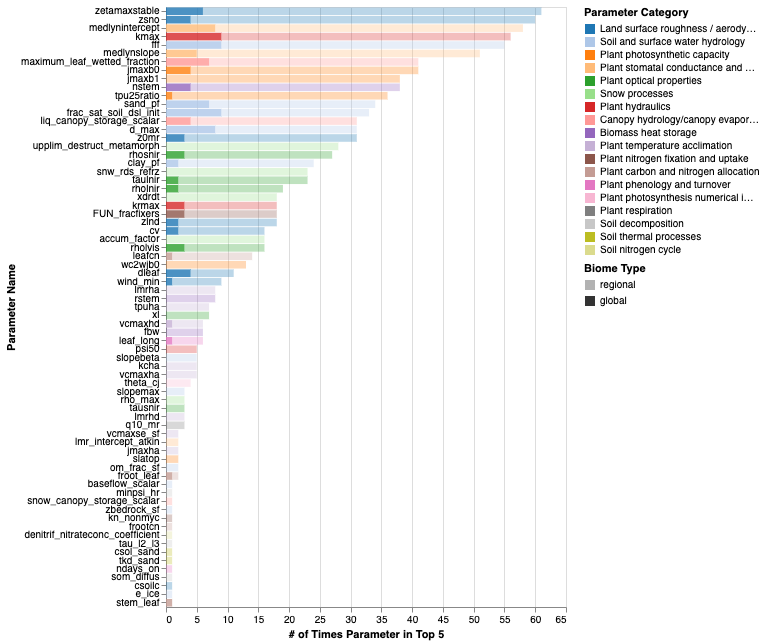

In [78]:
base.save('figs/Top5Counts_overall'+datetag+'.html')
base

### Top 5 Counts by Parameter Category

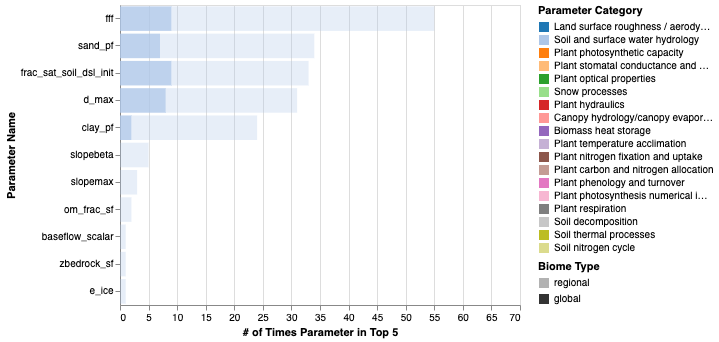

In [79]:
(top5counts_bycategory).save('figs/Top5Counts_byParameterCategory'+datetag+'.html')
top5counts_bycategory# | param_categories

### Top 5 Counts by Region

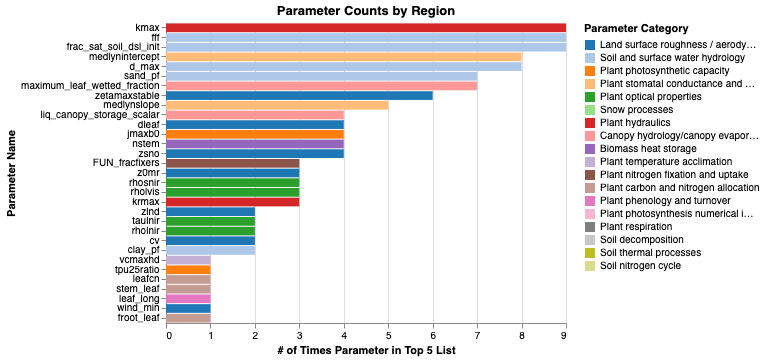

In [80]:
chart_by_region.save('figs/Top5Counts_byRegion'+datetag+'.html')
chart_by_region

### Top 5 Counts by Output Variable

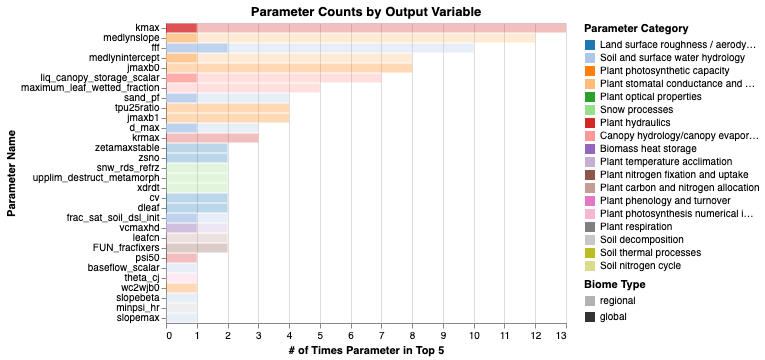

In [81]:
chart_by_variable.save('figs/Top5Counts_byVariable'+datetag+'.html')
chart_by_variable

### For which metrics is a parameter in the top 5?

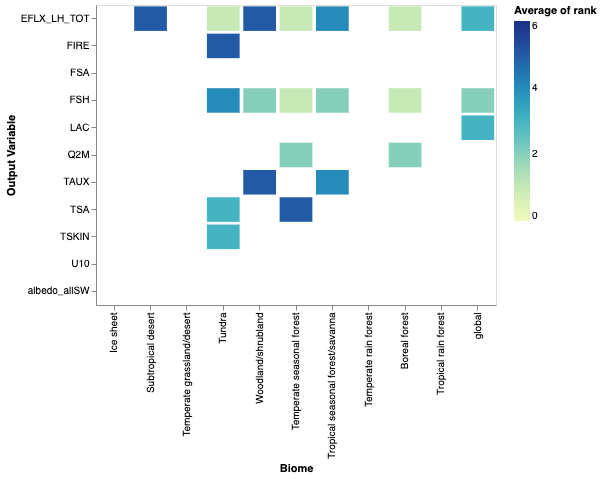

In [82]:
param_stats_viz = param_stats.add_selection(measure_select).transform_filter(measure_select)
param_stats_viz.save('figs/ParamStats'+datetag+'.html')
param_stats_viz